# Notebook 03: European Divergence Dashboard (CHF vs. EUR)
#
# **Pair:** Swiss Franc Futures (/6C) vs. Euro FX Futures (/6E)
# **Thesis:** Tracking the "European Divergence" trade.
#
# **Classic Correlation (Positive):**
# * **"Broad USD Move":** A strong/weak DXY (Dollar Index) causes both
#     the CHF and EUR to move together (inversely to the USD). The pair
#     is correlated, and the EUR/CHF cross is stable.
#
# **Decorrelation (The "Arbitrage"):**
# * **"EU-Specific Crisis":** A sovereign debt (e.g., Italy) or political
#     crisis sparks a "flight to quality" *within* Europe. Capital flees
#     the EUR (/6E falls) and flows *into* the CHF (/6C rises).
# * **"Policy Divergence":** The SNB (Swiss) turns hawkish to fight
#     inflation while the ECB (Euro) stays dovish to support growth,
#     driving the CHF up vs. the EUR.
#
# **Proxies Used:**
# * `/6C=F` (CHF Future) -> `FXF` (CHF ETF for clean price history)
# * `/6E=F` (EUR Future) -> `FXE` (EUR ETF for clean price history)
#
# **Causal Drivers (OSINT):**
# * `IRLTLT01ITM156N`: Italy 10-Yr Bond Yield.
# * `IRLTLT01DEM156N`: Germany 10-Yr Bond Yield.
#     * (Used to create the **BTP-Bund Spread**, our #1 EU Risk proxy).
# * `CPALTT01CHM656N`: Switzerland CPI (Monthly).
# * `CPHPTT01EZM656N`: Euro Area HICP (Monthly).
#     * (Used to create the **Inflation Differential**, our Policy proxy).

In [1]:
# Cell 1: Imports
#
# Import all necessary libraries for data, analysis, and visualization.
import yfinance as yf
from fredapi import Fred
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import zscore
import requests
import os
import json
from datetime import datetime, timedelta

# Configure Pandas for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

print("✅ Cell 1: Libraries imported successfully.")

✅ Cell 1: Libraries imported successfully.


In [ ]:
# Cell 2: API & LLM Configuration (Refactored)
#
# Set up API keys, LLM endpoints, and asset tickers.
# ADDED: Volatility ticker EVZCLS for Euro FX Volatility.

# --- FRED API Configuration ---
# ❗️ REQUIRES YOUR KEY: Get one from https://fred.stlouisfed.org/
os.environ.setdefault("FRED_API_KEY", "24a7e70f4690fbab7d2571d335107c68")

# --- LLM Configuration (Reused from your example) ---
os.environ.setdefault("LLM_BASE_URL", "http://127.0.0.1:11434") # Local Ollama server
os.environ.setdefault("LLM_MODEL", "qwen2.5:7b") # Your preferred model

def ask_llm(prompt: str, model=None, temperature=0.1):
    """Send a prompt to Ollama's CHAT endpoint and return the generated text."""
    model_to_use = model or os.getenv("LLM_MODEL")
    url_to_use = f"{os.getenv('LLM_BASE_URL')}/api/chat"

    chat_payload = {
        "model": model_to_use,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {"temperature": temperature},
        "stream": False
    }
    
    try:
        response = requests.post(url_to_use, json=chat_payload)
        response.raise_for_status()
        json_response = response.json()
        if "message" in json_response and "content" in json_response["message"]:
            return json_response["message"]["content"]
        else:
            return "Error: Unexpected response structure from /api/chat"
    except Exception as e:
        print(f"❌ LLM Error: {e}")
        return f"Error connecting to LLM at {url_to_use}. Is Ollama running?"

# --- Asset & Driver Configuration ---
YFINANCE_TICKERS = ["FXF", "FXE"]
FRED_SERIES_IDS = [
    "IRLTLT01ITM156N", # Italy 10Y Yield
    "IRLTLT01DEM156N", # Germany 10Y Yield
    "CPALTT01CHM657N", # Switzerland CPI (Your new ticker)
    "CP0000EZ19M086NEST",  # Euro Area HICP (Your new ticker)
    "VIXCLS"           # CBOE Euro FX Volatility Index
]

# --- Date Range Configuration ---
END_DATE = datetime.now()
START_DATE = END_DATE - timedelta(days=5 * 365) # 5 years of data

print("✅ Cell 2: Configuration loaded.")
print(f"Fetching data for: {YFINANCE_TICKERS} and {FRED_SERIES_IDS}")

✅ Cell 2: Configuration loaded.
Fetching data for: ['FXF', 'FXE'] and ['IRLTLT01ITM156N', 'IRLTLT01DEM156N', 'CPALTT01CHM657N', 'CP0000EZ19M086NEST', 'VIXCLS']


In [3]:
# Cell 3: Data Collection - yfinance
#
# Fetch historical price data for our ETF proxies (FXF, FXE).
try:
    print(f"Fetching yfinance data from {START_DATE.date()} to {END_DATE.date()}...")

    yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)

    # Select the 'Close' column for each ticker
    df_yf = yf_data.xs('Close', level=0, axis=1).copy()
    df_yf.index = pd.to_datetime(df_yf.index)

    print("✅ Cell 3: yfinance data fetched successfully.")
    print(df_yf.tail())
except Exception as e:
    print(f"❌ Cell 3: yfinance data fetch failed: {e}")

Fetching yfinance data from 2020-11-04 to 2025-11-03...


/tmp/ipykernel_889824/2504149046.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  yf_data = yf.download(YFINANCE_TICKERS, start=START_DATE, end=END_DATE)


[*********************100%***********************]  2 of 2 completed

✅ Cell 3: yfinance data fetched successfully.
Ticker             FXE         FXF
Date                              
2025-10-27  107.519997  111.279999
2025-10-28  107.540001  111.580002
2025-10-29  107.050003  110.570000
2025-10-30  106.720001  110.309998
2025-10-31  106.370003  109.959999


In [4]:
# Cell 4: Data Collection - FRED
#
# Fetch historical macro data for our causal drivers from FRED.
# Note: CPI data is monthly, so ffill() will be critical.
try:
    print("Fetching FRED data...")
    fred = Fred(api_key=os.getenv("FRED_API_KEY"))
    
    df_fred_list = []
    for series_id in FRED_SERIES_IDS:
        series = fred.get_series(series_id, START_DATE, END_DATE)
        df_fred_list.append(series.rename(series_id))
        
    df_fred = pd.concat(df_fred_list, axis=1)
    df_fred.index = pd.to_datetime(df_fred.index)

    print("✅ Cell 4: FRED data fetched successfully.")
    print(df_fred.tail())

except Exception as e:
    print(f"❌ Cell 4: FRED data fetch failed. Is your API key correct?")
    print(e)

Fetching FRED data...


✅ Cell 4: FRED data fetched successfully.
            IRLTLT01ITM156N  IRLTLT01DEM156N  CPALTT01CHM657N  CP0000EZ19M086NEST  VIXCLS
2025-10-27              NaN              NaN              NaN                 NaN   15.79
2025-10-28              NaN              NaN              NaN                 NaN   16.42
2025-10-29              NaN              NaN              NaN                 NaN   16.92
2025-10-30              NaN              NaN              NaN                 NaN   16.91
2025-10-31              NaN              NaN              NaN                 NaN   17.44


In [ ]:
# Cell 5: Data Consolidation & Cleaning
#
# Merge the yfinance (market) and FRED (macro) data into a single DataFrame.
# Use 'outer' join to keep all dates, then 'ffill' to fill monthly data.
try:
    df = pd.merge(df_yf, df_fred, left_index=True, right_index=True, how='outer')
    
    # Forward-fill missing values (CRITICAL for monthly CPI data)
    df = df.ffill()
    
    # Drop any initial NaNs from the start of the dataset
    df = df.dropna()
    
    print("✅ Cell 5: Data consolidated and cleaned.")
    print(df.tail())
    
except Exception as e:
    print(f"❌ Cell 5: Data merge failed: {e}")

✅ Cell 5: Data consolidated and cleaned.
                   FXE         FXF  IRLTLT01ITM156N  IRLTLT01DEM156N  CPALTT01CHM657N  CP0000EZ19M086NEST  VIXCLS
2025-10-27  107.519997  111.279999            3.559         2.693333         0.031103              129.37   15.79
2025-10-28  107.540001  111.580002            3.559         2.693333         0.031103              129.37   16.42
2025-10-29  107.050003  110.570000            3.559         2.693333         0.031103              129.37   16.92
2025-10-30  106.720001  110.309998            3.559         2.693333         0.031103              129.37   16.91
2025-10-31  106.370003  109.959999            3.559         2.693333         0.031103              129.37   17.44


In [ ]:
# Cell 6: Feature Engineering - Normalization (Z-Scores)
#
# Normalize all data to compare them on the same scale.
try:
    df_normalized = pd.DataFrame(index=df.index)
    # Apply zscore, handling potential NaNs from different start dates
    for col in df.columns:
        df_normalized[col] = zscore(df[col].dropna())
    
    # Re-fill any NaNs created by z-scoring (if any)
    df_normalized = df_normalized.ffill().dropna()
    
    print("✅ Cell 6: Data normalized (Z-Scores).")
    print(df_normalized.describe()) # Describe shows mean ~0, std ~1
    
except Exception as e:
    print(f"❌ Cell 6: Normalization failed: {e}")

✅ Cell 6: Data normalized (Z-Scores).
                FXE           FXF  IRLTLT01ITM156N  IRLTLT01DEM156N  CPALTT01CHM657N  CP0000EZ19M086NEST        VIXCLS
count  1.318000e+03  1.318000e+03     1.318000e+03     1.318000e+03     1.318000e+03        1.318000e+03  1.318000e+03
mean  -6.900567e-16 -6.469281e-16     8.625708e-17    -1.725142e-16     2.156427e-17        1.638885e-15 -3.881569e-16
std    1.000380e+00  1.000380e+00     1.000380e+00     1.000380e+00     1.000380e+00        1.000380e+00  1.000380e+00
min   -2.529081e+00 -2.395340e+00    -1.785832e+00    -1.745296e+00    -1.650554e+00       -1.874925e+00 -1.439009e+00
25%   -6.649238e-01 -5.031463e-01    -8.977988e-01    -1.119227e+00    -3.938051e-01       -1.003660e+00 -7.199939e-01
50%   -1.998243e-01 -1.500597e-01     4.028490e-01     5.449098e-01    -3.938051e-01        4.275258e-01 -2.050623e-01
75%    9.310669e-01  4.365125e-01     7.672640e-01     7.819029e-01     4.272277e-01        8.568815e-01  5.276525e-01
max    1.9

In [ ]:
# Cell 7: Feature Engineering - Ratios & Spreads (Refactored)
#
# (Using your new CPI tickers)
#
# * Ratio: The price of CHF (FXF) divided by the price of EUR (FXE).
#     A RISING ratio signals CHF is outperforming EUR (our thesis).
# * Causal Spreads: The *drivers* of the decorrelation.

try:
    # 1. Price Ratio (The Core Signal)
    df['CHF_EUR_Ratio'] = df['FXF'] / df['FXE']
    
    # 2. Normalized Price Spread (Divergence Magnitude)
    df['CHF_EUR_Spread_Norm'] = df_normalized['FXF'] - df_normalized['FXE']
    
    # 3. Causal Spread 1: EU Risk (BTP-Bund Spread)
    # (Italy 10Y Yield - Germany 10Y Yield)
    # Multiplying by 100 to convert to basis points (bps)
    df['EU_Risk_Spread'] = (df['IRLTLT01ITM156N'] - df['IRLTLT01DEM156N']) * 100
    
    # 4. Causal Spread 2: Policy Divergence (Inflation Differential)
    # (Swiss CPI - Euro Area CPI)
    df['Inflation_Differential'] = df['CPALTT01CHM657N'] - df['CP0000EZ19M086NEST']

    print("✅ Cell 7: Ratios and Spreads calculated.")
    print(df[['CHF_EUR_Ratio', 'EU_Risk_Spread', 'Inflation_Differential']].tail())
    
except Exception as e:
    print(f"❌ Cell 7: Ratio/Spread calculation failed: {e}")

✅ Cell 7: Ratios and Spreads calculated.
            CHF_EUR_Ratio  EU_Risk_Spread  Inflation_Differential
2025-10-27       1.034970       86.566667             -129.338897
2025-10-28       1.037567       86.566667             -129.338897
2025-10-29       1.032882       86.566667             -129.338897
2025-10-30       1.033639       86.566667             -129.338897
2025-10-31       1.033750       86.566667             -129.338897


In [ ]:
# Cell 8: Feature Engineering - Rolling Correlations
#
# Calculate the 30-day and 90-day rolling correlations between
# the *daily returns* of FXF and FXE.
# * Correlation near 1.0 = "Broad USD Move" regime.
# * Correlation falling/negative = "Divergence" regime.

try:
    # First, get daily percentage returns
    df['FXF_pct'] = df['FXF'].pct_change()
    df['FXE_pct'] = df['FXE'].pct_change()
    
    # Calculate rolling correlations
    df['Corr_30D'] = df['FXF_pct'].rolling(window=30).corr(df['FXE_pct'])
    df['Corr_90D'] = df['FXF_pct'].rolling(window=90).corr(df['FXE_pct'])

    print("✅ Cell 8: Rolling correlations calculated.")
    print(df[['Corr_30D', 'Corr_90D']].tail())

except Exception as e:
    print(f"❌ Cell 8: Correlation calculation failed: {e}")

✅ Cell 8: Rolling correlations calculated.
            Corr_30D  Corr_90D
2025-10-27  0.935829  0.898591
2025-10-28  0.916176  0.901430
2025-10-29  0.905785  0.902171
2025-10-30  0.906432  0.901714
2025-10-31  0.906471  0.902249


In [ ]:
# Cell 8a: Feature Engineering - Historical Volatility (NEW)
#
# Calculate 30-day Historical (Realized) Volatility (HV) for our assets.
# This will be compared against Implied Volatility (IV).

try:
    # Calculate 30-day rolling HV (annualized)
    df['FXF_HV_30D'] = df['FXF_pct'].rolling(window=30).std() * np.sqrt(252)
    df['FXE_HV_30D'] = df['FXE_pct'].rolling(window=30).std() * np.sqrt(252)

    print("✅ Cell 8a: Historical Volatility (HV) calculated.")
    print(df[['FXF_HV_30D', 'FXE_HV_30D']].tail())

except Exception as e:
    print(f"❌ Cell 8a: HV calculation failed: {e}")

✅ Cell 8a: Historical Volatility (HV) calculated.
            FXF_HV_30D  FXE_HV_30D
2025-10-27    0.066803    0.060100
2025-10-28    0.060204    0.054475
2025-10-29    0.064937    0.055105
2025-10-30    0.063059    0.054894
2025-10-31    0.063040    0.054992


In [ ]:
# Cell 8b: Feature Engineering - IV Rank (Refactored)
#
# Calculate the 1-year (252-day) Implied Volatility Rank (IVR).
# We use VIXCLS (Global Risk) as the primary vol metric for this pair.
# IVR = 100 * (Current IV - 52wk Low) / (52wk High - 52wk Low)

try:
    # Calculate 252-day rolling min/max for VIX
    df['VIX_min_252D'] = df['VIXCLS'].rolling(window=252).min()
    df['VIX_max_252D'] = df['VIXCLS'].rolling(window=252).max()
    
    # Calculate IV Rank
    df['VIX_IVR_252D'] = 100 * (df['VIXCLS'] - df['VIX_min_252D']) / (df['VIX_max_252D'] - df['VIX_min_252D'])

    print("✅ Cell 8b: Implied Volatility Rank (IVR) calculated.")
    print(df[['VIXCLS', 'VIX_IVR_252D']].tail())

except Exception as e:
    print(f"❌ Cell 8b: IV Rank calculation failed: {e}")

✅ Cell 8b: Implied Volatility Rank (IVR) calculated.
            VIXCLS  VIX_IVR_252D
2025-10-27   15.79      7.633974
2025-10-28   16.42      9.226491
2025-10-29   16.92     10.490394
2025-10-30   16.91     10.465116
2025-10-31   17.44     11.804853


In [ ]:
# Cell 8c: Feature Engineering - VRP & Signal Velocity (Refactored)
#
# Calculate the Volatility Risk Premium (VRP) and Signal Velocity.
# We compare the single VIX proxy against the HV of each asset.
#
# Signal Velocity = 5-day change in the normalized spread.

try:
    # 1. Volatility Risk Premium (VRP)
    df['FXE_VRP'] = df['VIXCLS'] - df['FXE_HV_30D']
    df['FXF_VRP'] = df['VIXCLS'] - df['FXF_HV_30D']
    
    # 2. Signal Velocity
    df['Signal_Velocity_5D'] = df['CHF_EUR_Spread_Norm'].diff(5)

    print("✅ Cell 8c: VRP and Signal Velocity calculated.")
    print(df[['FXE_VRP', 'FXF_VRP', 'Signal_Velocity_5D']].tail())
    
    # Drop NaNs created by all the new rolling windows to clean the final df
    df = df.dropna()

except Exception as e:
    print(f"❌ Cell 8c: VRP/Velocity calculation failed: {e}")

✅ Cell 8c: VRP and Signal Velocity calculated.
              FXE_VRP    FXF_VRP  Signal_Velocity_5D
2025-10-27  15.729900  15.723197           -0.116015
2025-10-28  16.365525  16.359796           -0.005374
2025-10-29  16.864895  16.855063           -0.109533
2025-10-30  16.855106  16.846941           -0.115812
2025-10-31  17.385008  17.376960           -0.102198


Plotting Cell 9: Core Thesis...


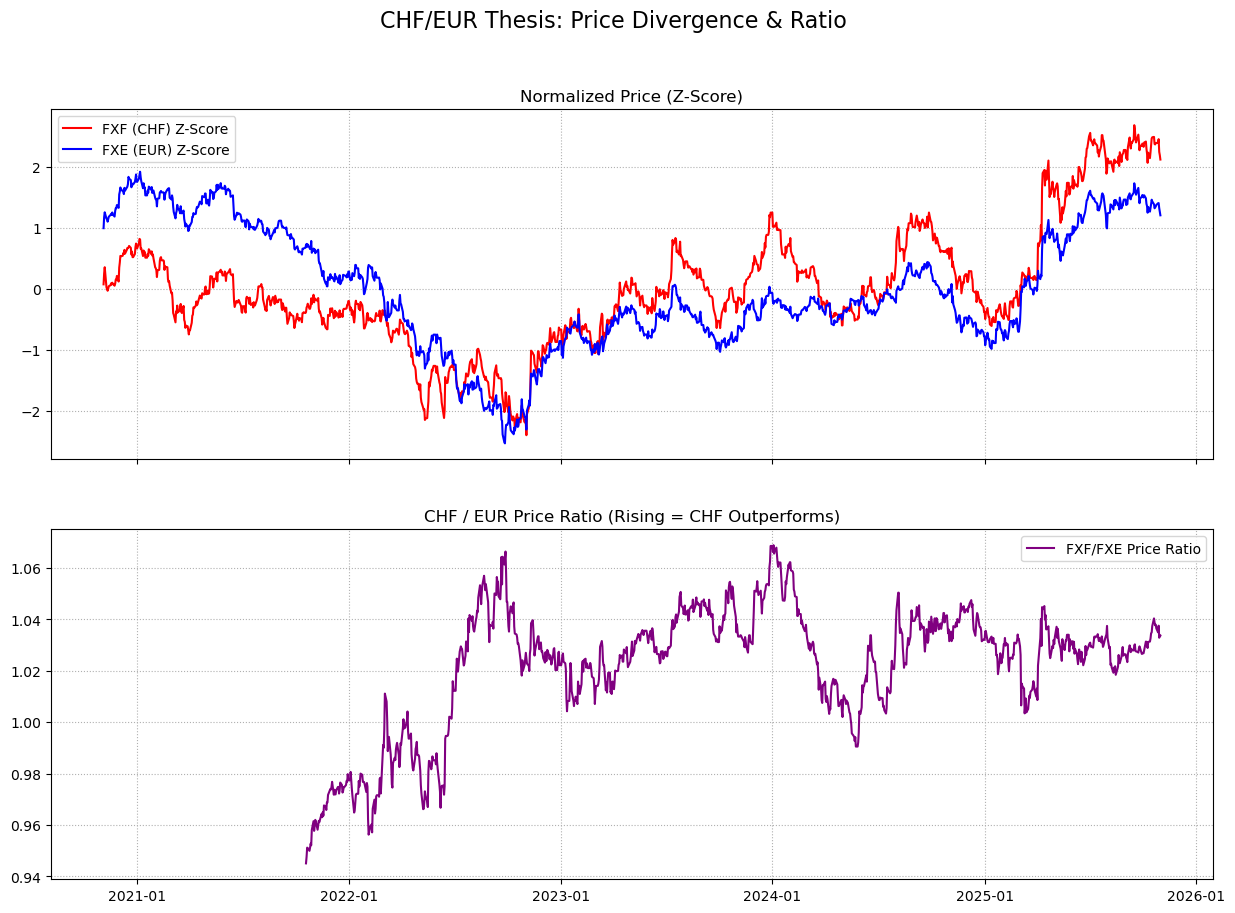

In [12]:
# Cell 9: Visualization - Core Thesis (Price vs. Ratio)
#
# Plot 1: Normalized prices of FXF vs. FXE.
# Plot 2: The FXF/FXE Ratio.
#
# This chart shows *what* is happening. When the lines in Plot 1
# diverge, the line in Plot 2 will trend.

try:
    print("Plotting Cell 9: Core Thesis...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('CHF/EUR Thesis: Price Divergence & Ratio', fontsize=16)

    # Plot 1: Normalized Prices
    ax1.plot(df_normalized.index, df_normalized['FXF'], label='FXF (CHF) Z-Score', color='red')
    ax1.plot(df_normalized.index, df_normalized['FXE'], label='FXE (EUR) Z-Score', color='blue')
    ax1.set_title('Normalized Price (Z-Score)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # Plot 2: Price Ratio
    ax2.plot(df.index, df['CHF_EUR_Ratio'], label='FXF/FXE Price Ratio', color='purple')
    ax2.set_title('CHF / EUR Price Ratio (Rising = CHF Outperforms)')
    ax2.legend()
    ax2.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 9: Plotting failed: {e}")

Plotting Cell 10: Causal Drivers...


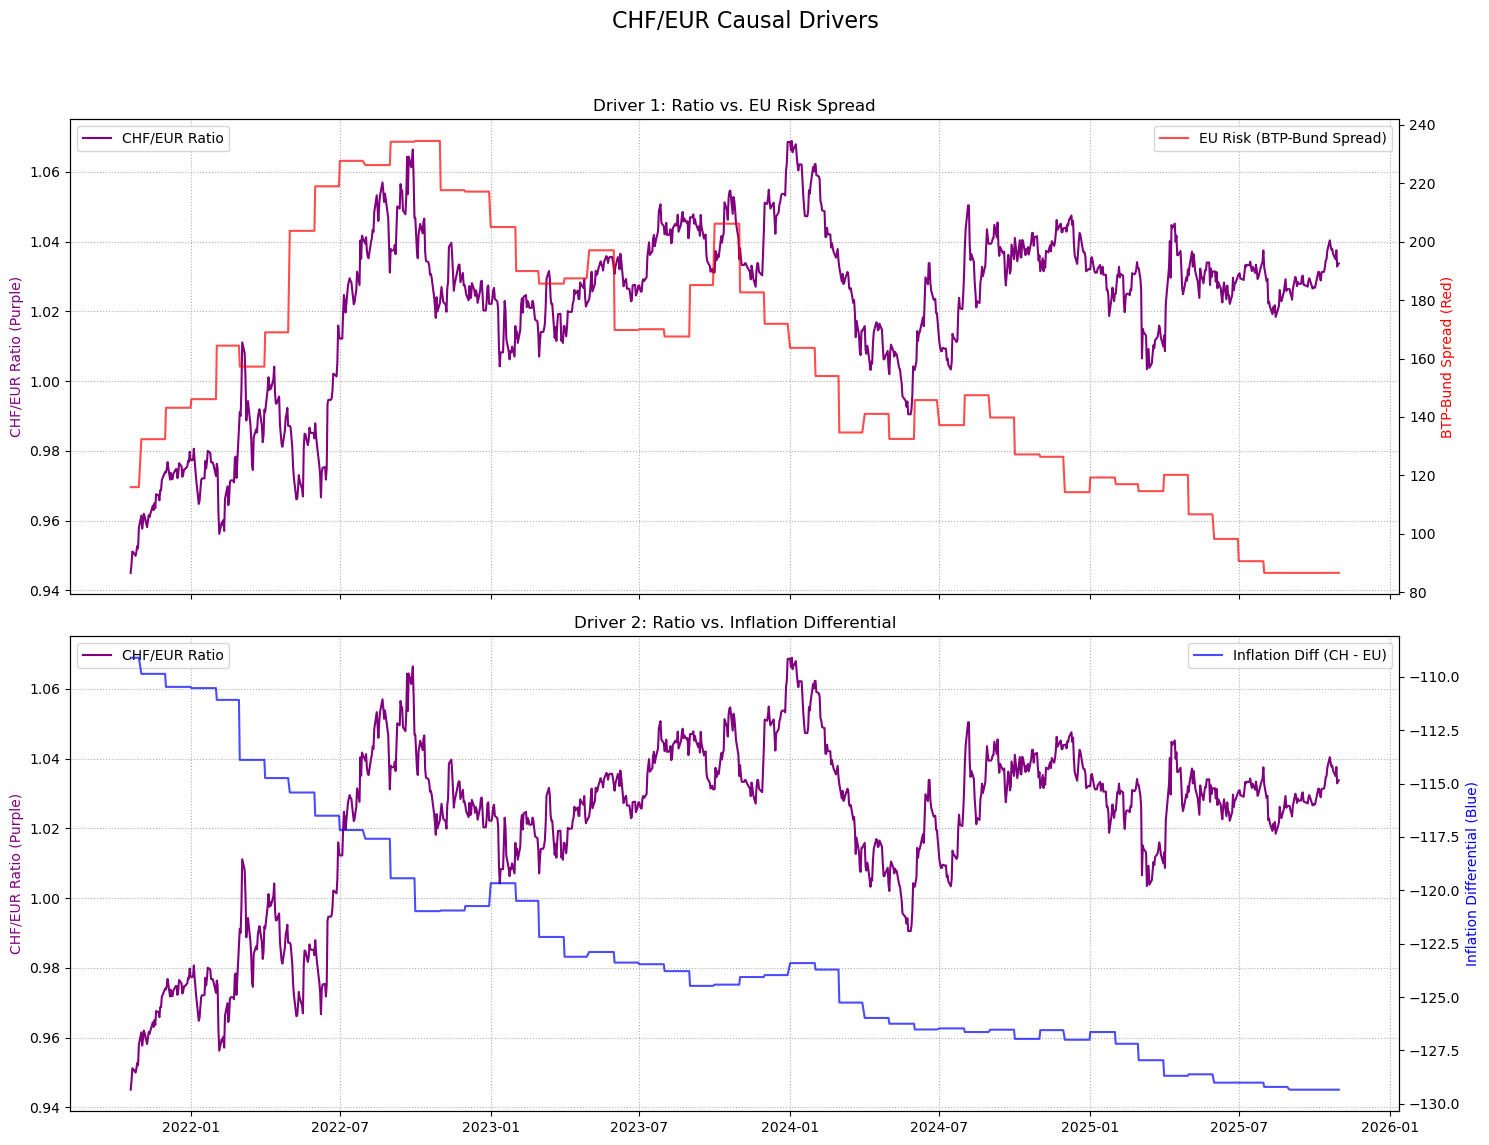

In [13]:
# Cell 10: Visualization - Causal Drivers (Risk & Policy)
#
# Plot 1: The Ratio vs. the EU Risk Spread (BTP-Bund).
# Plot 2: The Ratio vs. the Inflation Differential (CH-EU).
#
# This chart shows *why* the ratio is moving.
# Thesis 1: Ratio (purple) should follow EU Risk (red).
# Thesis 2: Ratio (purple) should follow Inflation Diff (blue).

try:
    print("Plotting Cell 10: Causal Drivers...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    fig.suptitle('CHF/EUR Causal Drivers', fontsize=16)

    # --- Plot 1: EU Risk Driver ---
    ax1.plot(df.index, df['CHF_EUR_Ratio'], label='CHF/EUR Ratio', color='purple')
    ax1.set_ylabel('CHF/EUR Ratio (Purple)', color='purple')
    ax1.legend(loc='upper left')
    ax1.grid(True, linestyle=':')
    
    ax1_twin = ax1.twinx()
    ax1_twin.plot(df.index, df['EU_Risk_Spread'], label='EU Risk (BTP-Bund Spread)', color='red', alpha=0.7)
    ax1_twin.set_ylabel('BTP-Bund Spread (Red)', color='red')
    ax1_twin.legend(loc='upper right')
    ax1.set_title('Driver 1: Ratio vs. EU Risk Spread')

    # --- Plot 2: Inflation/Policy Driver ---
    ax2.plot(df.index, df['CHF_EUR_Ratio'], label='CHF/EUR Ratio', color='purple')
    ax2.set_ylabel('CHF/EUR Ratio (Purple)', color='purple')
    ax2.legend(loc='upper left')
    ax2.grid(True, linestyle=':')

    ax2_twin = ax2.twinx()
    ax2_twin.plot(df.index, df['Inflation_Differential'], label='Inflation Diff (CH - EU)', color='blue', alpha=0.7)
    ax2_twin.set_ylabel('Inflation Differential (Blue)', color='blue')
    ax2_twin.legend(loc='upper right')
    ax2.set_title('Driver 2: Ratio vs. Inflation Differential')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for suptitle
    plt.show()

except Exception as e:
    print(f"❌ Cell 10: Plotting failed: {e}")

Plotting Cell 11: Correlation Breakdown...


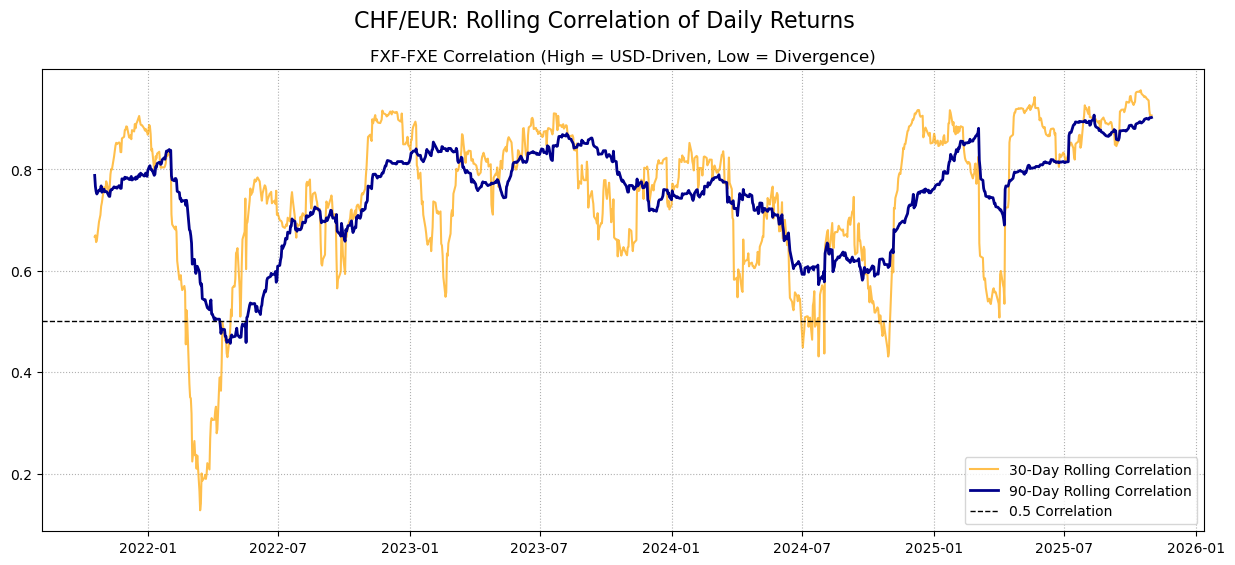

In [ ]:
# Cell 11: Visualization - Correlation Breakdown
#
# Plot the 30-day and 90-day rolling correlation of returns.
#
# This chart quantifies the regime.
# * High (near 1.0) = Correlated "Broad USD" regime.
# * Falling/Low = "Divergence" regime.

try:
    print("Plotting Cell 11: Correlation Breakdown...")
    fig, ax1 = plt.subplots(figsize=(15, 6))
    fig.suptitle('CHF/EUR: Rolling Correlation of Daily Returns', fontsize=16)

    ax1.plot(df.index, df['Corr_30D'], label='30-Day Rolling Correlation', color='orange', alpha=0.7)
    ax1.plot(df.index, df['Corr_90D'], label='90-Day Rolling Correlation', color='darkblue', linewidth=2)
    ax1.axhline(0.5, color='black', linestyle='--', linewidth=1, label='0.5 Correlation')
    ax1.set_title('FXF-FXE Correlation (High = USD-Driven, Low = Divergence)')
    ax1.legend()
    ax1.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 11: Plotting failed: {e}")

Plotting Cell 11a: Volatility Dashboard...


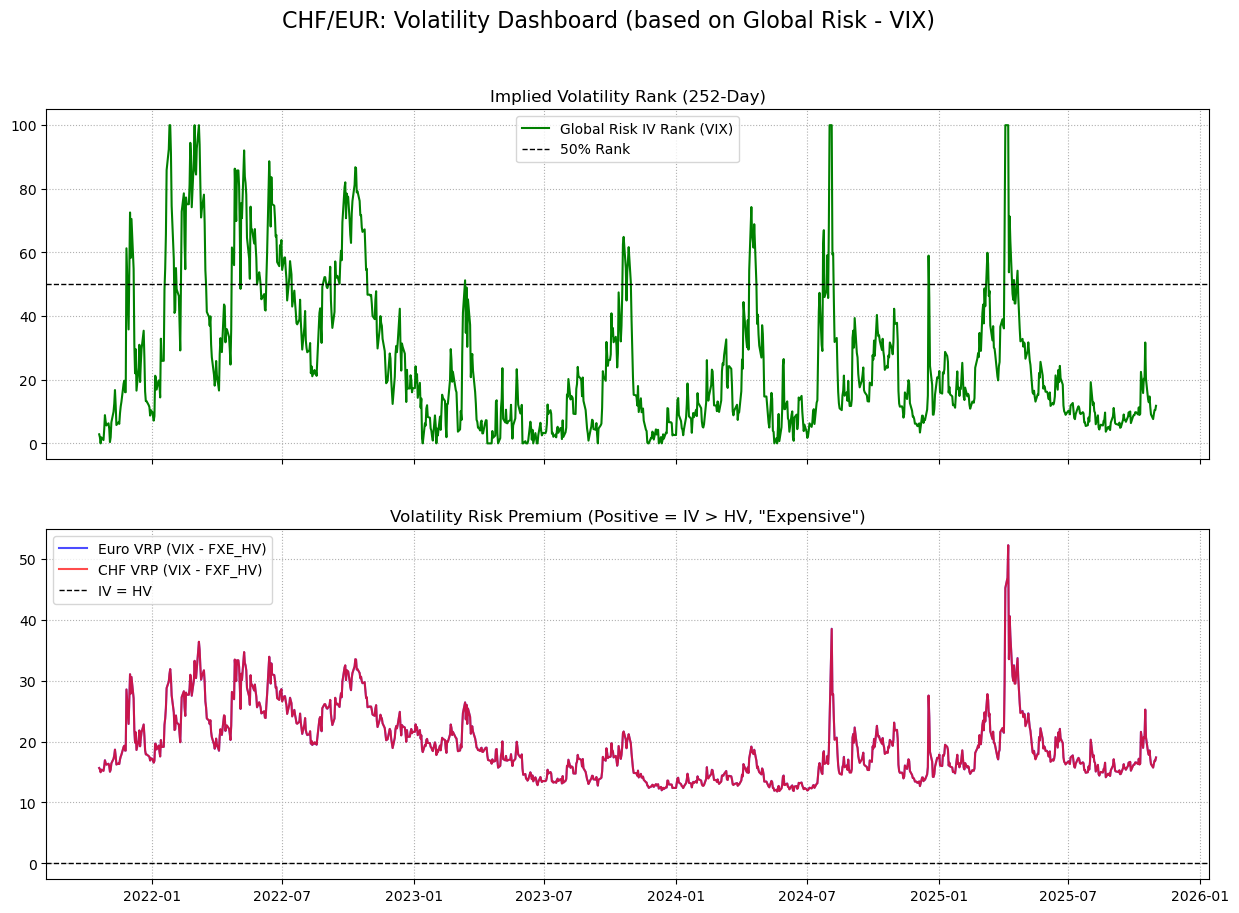

In [15]:
# Cell 11a: Visualization - Volatility Dashboard (Refactored)
#
# Plot the IV Rank (from VIX) and the VRP for both assets.

try:
    print("Plotting Cell 11a: Volatility Dashboard...")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
    fig.suptitle('CHF/EUR: Volatility Dashboard (based on Global Risk - VIX)', fontsize=16)

    # Plot 1: IV Rank (Tells you if vol is "high" or "low")
    ax1.plot(df.index, df['VIX_IVR_252D'], label='Global Risk IV Rank (VIX)', color='green')
    ax1.axhline(50, color='black', linestyle='--', linewidth=1, label='50% Rank')
    ax1.set_title('Implied Volatility Rank (252-Day)')
    ax1.legend()
    ax1.grid(True, linestyle=':')

    # Plot 2: Volatility Risk Premium (IV vs HV)
    ax2.plot(df.index, df['FXE_VRP'], label='Euro VRP (VIX - FXE_HV)', color='blue', alpha=0.7)
    ax2.plot(df.index, df['FXF_VRP'], label='CHF VRP (VIX - FXF_HV)', color='red', alpha=0.7)
    ax2.axhline(0, color='black', linestyle='--', linewidth=1, label='IV = HV')
    ax2.set_title('Volatility Risk Premium (Positive = IV > HV, "Expensive")')
    ax2.legend()
    ax2.grid(True, linestyle=':')
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.show()

except Exception as e:
    print(f"❌ Cell 11a: Volatility plotting failed: {e}")

In [16]:
# Cell 12: LLM Analyst Synthesis (Refactored for Reasoning)
#
# This cell is for YOU. It runs the full qualitative analysis and
# outputs a human-readable synthesis. The output is saved to a
# variable for the next cell to parse.

try:
    print("Sending data to LLM for full analysis...")
    
    # Get the latest data row
    latest_data = df.iloc[-1]
    
    # --- Create Data Summary ---
    
    # 1. Macro Theme Summary
    macro_summary = f"""
--- MACRO THEME (Pair: CHF/EUR) ---
- **Thematic Bias:** European Divergence
- **Signal Strength (Z-Score):** {latest_data['CHF_EUR_Spread_Norm']:.2f}
- **Signal Velocity (5D Change):** {latest_data['Signal_Velocity_5D']:.2f}
- **Regime Type (90D Corr):** {latest_data['Corr_90D']:.3f} (High = USD-Driven, Low = Divergence)
- **EU Risk Driver (BTP-Bund):** {latest_data['EU_Risk_Spread']:.2f} bps
- **Policy Driver (Infl. Diff):** {latest_data['Inflation_Differential']:.2f}%
"""
    
    # 2. Volatility Dashboard Summary
    vol_summary = f"""
--- VOLATILITY DASHBOARD (Global Risk Proxy: VIX) ---
- **Implied Vol (VIXCLS):** {latest_data['VIXCLS']:.2f}
- **IV Rank (1-Year):** {latest_data['VIX_IVR_252D']:.1f}%
- **FXE VRP (VIX - HV):** {latest_data['FXE_VRP']:.2f} (Positive = "Expensive")
- **FXF VRP (VIX - HV):** {latest_data['FXF_VRP']:.2f} (Positive = "Expensive")
"""
    
    # 3. Determine Target Asset and Bias
    if latest_data['CHF_EUR_Spread_Norm'] > 0:
        target_asset = "FXE (via Short EUR)"
        directional_bias = "Bearish"
    else:
        target_asset = "FXE (via Long EUR)"
        directional_bias = "Bullish"

    # --- Create the LLM Prompt ---
    prompt = f"""
**Role:** You are an Independent Intelligence Desk Analyst, as per my thesis.

**Your Available Strategies:**
* Bull_Put_Spread, Bear_Call_Spread, Iron_Condor (Sell Premium)
* Calendar_Spread, Diagonal_Spread, Double_Diagonal_Spread (Buy Vega)
* No_Trade

**Latest OSINT Data:**
{macro_summary}
{vol_summary}

**Your Task (Provide a 3-part recommendation):**
1.  **Volatility Regime:** Based on the **VIX IV Rank**, is global risk volatility "High/Expensive" or "Low/Cheap"? Explain *why* this favors selling premium or buying vega.
2.  **Thematic Regime:** Based on Signal Strength, Correlation, and the `EU_Risk_Spread`, is the macro theme a "Strong Divergence" (Strong Trend) or a "Correlated Chop" (Range)? Explain your reasoning.
3.  **Strategy Route:** Combine these two analyses to select the *optimal* strategy. The macro theme gives a **{directional_bias}** bias on **{target_asset}**. Explain *why* this strategy is the best fit.
    
    **Routing Logic:**
    * **High IVR (>50) + Strong Trend:** Use a directionally-biased *credit spread* (e.g., {'Bear_Call_Spread' if directional_bias == 'Bearish' else 'Bull_Put_Spread'} on FXE).
    * **High IVR (>50) + Range/Chop:** Use a *neutral* credit strategy (e.g., Iron_Condor on FXE).
    * **Low IVR (<50) + Strong Trend:** Use a directionally-biased *debit/vega* strategy (e.g., {'Diagonal_Spread' if directional_bias == 'Bearish' else 'Diagonal_Spread'} on FXE).
    * **Low IVR (<50) + Range/Chop:** Use a *neutral* vega strategy (e.g., Calendar_Spread on FXE) or No_Trade.
"""
    
    # Get LLM response
    llm_analyst_report = ask_llm(prompt) # This is the full, verbose report
    
    # --- Store data for subsequent cells ---
    latest_trade_data = latest_data.to_dict()
    latest_trade_data['Date'] = latest_data.name 
    latest_trade_rec = {"target_asset": target_asset} # Store target
    
    print("\n--- 🤖 LLM ANALYST REPORT ---")
    print(llm_analyst_report)
    print("---------------------------------")

except Exception as e:
    print(f"❌ Cell 12: LLM Analyst synthesis failed: {e}")

Sending data to LLM for full analysis...



--- 🤖 LLM ANALYST REPORT ---
### 1. Volatility Regime

**Global Risk Volatility: Low/Cheap**

- **Explanation:** The VIX IV Rank is currently at 11.8%, which places it in the bottom 10% of its historical range (considering a 1-year period). This indicates that implied volatility is relatively low compared to recent history, making options "cheap." Given this environment, selling premium strategies would be more favorable because you can collect higher premiums for writing options when volatility is low. Selling premium strategies include the Bull_Put_Spread and Bear_Call_Spread.

### 2. Thematic Regime

**Thematic Regime: Correlated Chop**

- **Explanation:** 
  - The Signal Strength (Z-Score) of 0.91 suggests a moderate divergence, but not a strong one.
  - The Regime Type (90D Correlation) at 0.902 indicates that the CHF/EUR pair is highly correlated with USD movements, which means there isn't a clear trend or divergence.
  - The EU Risk Driver (BTP-Bund spread) of 86.57 bps and Pol

In [17]:
# Cell 13: Signal Extraction (NEW)
#
# This cell is for the MACHINE. It takes the verbose report from Cell 12,
# feeds it *back* to the LLM, and forces it to parse its *own*
# reasoning into a single, clean signal for the sizing and logging cells.

try:
    print("Parsing analyst report for a clean signal...")
    
    strategy_list = [
        "Bull_Put_Spread", "Bear_Call_Spread", "Iron_Condor",
        "Calendar_Spread", "Diagonal_Spread", "Double_Diagonal_Spread",
        "No_Trade"
    ]
    
    # Create the *second* prompt (the parser)
    parser_prompt = f"""
You are a simple parsing bot. Read the following analyst report. Your *only* job is to identify which strategy from the provided list was recommended.

**Strategy List:** {', '.join(strategy_list)}

**Analyst Report:**
"{llm_analyst_report}"

**Your Response:**
Respond with *only* the single, exact strategy name from the list. For example: Bull_Put_Spread
"""

    # Get the parsed response
    parsed_strategy = ask_llm(parser_prompt, temperature=0.0) # Temp 0.0 for deterministic parsing
    
    # Clean up any extra text
    parsed_strategy = parsed_strategy.strip()
    
    if parsed_strategy not in strategy_list:
        print(f"⚠️ Warning: LLM parser returned an unknown strategy: '{parsed_strategy}'. Defaulting to 'No_Trade'.")
        parsed_strategy = "No_Trade"
        
    # --- Store for Cells 14 and 15 ---
    latest_trade_rec['strategy'] = parsed_strategy
    
    print(f"✅ Cell 13: Parsed Strategy: {parsed_strategy}")

except Exception as e:
    print(f"❌ Cell 13: LLM parser failed: {e}")
    if 'latest_trade_rec' not in locals():
        latest_trade_rec = {}
    latest_trade_rec['strategy'] = "No_Trade" # Ensure variable exists

Parsing analyst report for a clean signal...
✅ Cell 13: Parsed Strategy: Iron_Condor


In [18]:
# Cell 14: Position Sizing (NEW)
#
# Apply Step 3 of your thesis ("Trade & risk discipline").
# This cell now reads the clean strategy from Cell 13.

import math

# --- Define Your Risk Parameters ---
ACCOUNT_VALUE = 100000.00  # Your total trading capital
RISK_BPS_PER_TRADE = 50  # 50 bps = 0.50% risk per trade

# --- Define Approx. Risk-Per-Contract (Based on your Specs) ---
RISK_PER_CONTRACT = {
    "Bull_Put_Spread": 350,
    "Bear_Call_Spread": 350,
    "Iron_Condor": 300,
    "Calendar_Spread": 150,
    "Diagonal_Spread": 200,
    "Double_Diagonal_Spread": 100,
    "No_Trade": 0
}

try:
    # --- Get Data from Cell 13 ---
    strategy = latest_trade_rec['strategy']
    target_asset = latest_trade_rec['target_asset']
    
    if strategy == "No_Trade" or strategy not in RISK_PER_CONTRACT:
        print("--- TRADE SIZING ---")
        print("Signal: No_Trade")
        latest_trade_rec['contracts'] = 0
    else:
        # --- Calculate Sizing ---
        risk_per_trade_usd = ACCOUNT_VALUE * (RISK_BPS_PER_TRADE / 10000.0)
        risk_per_unit = RISK_PER_CONTRACT.get(strategy, risk_per_trade_usd)
        
        if risk_per_unit <= 0: # Avoid division by zero
             contracts = 0
             print("Warning: Risk per contract is zero. No trade sized.")
        else:
            contracts = math.floor(risk_per_trade_usd / risk_per_unit)
            contracts = max(1, contracts) # Ensure at least 1 contract
        
        # --- Store for Cell 15 ---
        latest_trade_rec['contracts'] = contracts
        latest_trade_rec['risk_usd'] = risk_per_trade_usd
        
        # --- Print Final Trade Ticket ---
        print("--- ✅ FINAL TRADE TICKET ---")
        print(f"Date:       {latest_trade_data['Date'].strftime('%Y-%m-%d')}")
        print(f"Theme:      European Divergence (CHF/EUR)")
        print(f"Target:     {target_asset}")
        print(f"Strategy:   {strategy}")
        print(f"Size:       {contracts} contracts")
        print(f"Risk Rule:  {RISK_BPS_PER_TRADE} bps on ${ACCOUNT_VALUE:,.2f} = ${risk_per_trade_usd:,.2f} max risk")

except Exception as e:
    if 'latest_trade_rec' not in locals():
        latest_trade_rec = {}
    latest_trade_rec['contracts'] = 0
    print(f"❌ Cell 14: Position Sizing failed: {e}")

--- ✅ FINAL TRADE TICKET ---
Date:       2025-10-31
Theme:      European Divergence (CHF/EUR)
Target:     FXE (via Short EUR)
Strategy:   Iron_Condor
Size:       1 contracts
Risk Rule:  50 bps on $100,000.00 = $500.00 max risk


In [19]:
# Cell 15: Log to Trade Journal (NEW)
#
# This cell appends the final, sized trade and all its
# causal drivers to your "signals.csv" file.

import csv
import os.path

LOG_FILE = 'quant/trade_journal.csv'

try:
    # --- Get all data for logging ---
    data = latest_trade_data
    rec = latest_trade_rec

    # Define all the columns you want to log
    fieldnames = [
        'Date', 'Pair', 'Theme', 'Target_Asset', 'Strategy', 'Contracts_Sized',
        'Signal_ZScore', 'Signal_Velocity_5D', 'Corr_90D',
        'VIX_IVR', 'FXE_VRP', 'FXF_VRP', 
        'EU_Risk_Spread', 'Inflation_Differential',
        'Analyst_Reasoning' # Log the full reasoning
    ]
    
    # Create the data dictionary
    log_data = {
        'Date': data['Date'].strftime('%Y-%m-%d'),
        'Pair': 'CHF_EUR',
        'Theme': 'European_Divergence',
        'Target_Asset': rec.get('target_asset'),
        'Strategy': rec.get('strategy'),
        'Contracts_Sized': rec.get('contracts'),
        'Signal_ZScore': data.get('CHF_EUR_Spread_Norm'),
        'Signal_Velocity_5D': data.get('Signal_Velocity_5D'),
        'Corr_90D': data.get('Corr_90D'),
        'VIX_IVR': data.get('VIX_IVR_252D'),
        'FXE_VRP': data.get('FXE_VRP'),
        'FXF_VRP': data.get('FXF_VRP'),
        'EU_Risk_Spread': data.get('EU_Risk_Spread'),
        'Inflation_Differential': data.get('Inflation_Differential'),
        'Analyst_Reasoning': llm_analyst_report # Log the full text
    }
    
    # Check if file exists to write header or not
    file_exists = os.path.isfile(LOG_FILE)
    
    # Open in 'append' mode
    with open(LOG_FILE, 'a', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=fieldnames)
        
        if not file_exists:
            writer.writeheader()  # Write header only once
            
        writer.writerow(log_data)
        
    print(f"\n--- ✅ Trade Logged ---")
    print(f"Successfully appended trade signal to {LOG_FILE}")
    
except Exception as e:
    print(f"❌ Cell 15: Logging to CSV failed: {e}")


--- ✅ Trade Logged ---
Successfully appended trade signal to quant/trade_journal.csv
